In [1]:
import os, json, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import joblib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
CANDIDATE_FILES = ["HousingData.csv"]
csv_path = None
for name in CANDIDATE_FILES:
    if Path(name).exists():
        csv_path = name
        break
if csv_path is None:
    raise FileNotFoundError("Không tìm thấy file dữ liệu CSV")

df = pd.read_csv(csv_path)
drop_like = [c for c in df.columns if c.lower().startswith("unnamed")]
if drop_like:
    df = df.drop(columns=drop_like)

print("Kích thước dữ liệu:", df.shape)
print(df.head())

Kích thước dữ liệu: (506, 14)
      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90    NaN  36.2  


Missing values:
CRIM       20
ZN         20
INDUS      20
CHAS       20
LSTAT      20
AGE        20
RM          0
NOX         0
RAD         0
DIS         0
TAX         0
PTRATIO     0
B           0
MEDV        0
dtype: int64
Thống kê mô tả:
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  486.000000  486.000000  486.000000  486.000000  506.000000  506.000000   
mean     3.611874   11.211934   11.083992    0.069959    0.554695    6.284634   
std      8.720192   23.388876    6.835896    0.255340    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.081900    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.253715    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.560263   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS

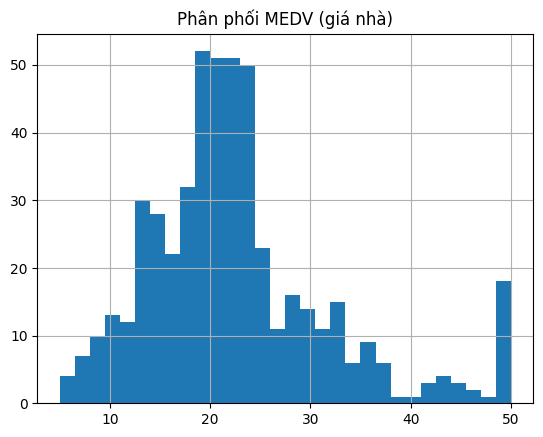

In [5]:
print("Missing values:")
print(df.isnull().sum().sort_values(ascending=False))
print("Thống kê mô tả:")
print(df.describe())

plt.figure()
df["MEDV"].hist(bins=30)
plt.title("Phân phối MEDV (giá nhà)")
plt.show()

In [6]:
def make_features(data: pd.DataFrame) -> pd.DataFrame:
    df2 = data.copy()
    if all(c in df2.columns for c in ["RM", "LSTAT"]):
        df2["RM_LSTAT"] = df2["RM"] * df2["LSTAT"]
        df2["RM2"] = df2["RM"] ** 2
        df2["LSTAT2"] = df2["LSTAT"] ** 2
    if all(c in df2.columns for c in ["TAX", "AGE"]):
        df2["TAX_AGE"] = df2["TAX"] * df2["AGE"]
    return df2

df_fe = make_features(df)
X_full = df_fe.drop(columns=["MEDV"])
y = df_fe["MEDV"].values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, random_state=42
)

In [8]:
from sklearn.impute import SimpleImputer

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def evaluate_holdout(name, model):
    # Create a pipeline for each model that includes imputation
    pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")), # Add imputer here
        ("model", model)
    ])
    pipeline.fit(X_train, y_train)
    pred = pipeline.predict(X_test)
    return {
        "model": name,
        "RMSE": rmse(y_test, pred),
        "MAE": mean_absolute_error(y_test, pred),
        "R2": r2_score(y_test, pred)
    }

# No need to include StandardScaler in the evaluate_holdout function anymore
# as it's part of the pipeline definition for Linear Regression below.
pipe_lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
gbr = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42)

models = {"Linear Regression": pipe_lr, "Random Forest": rf, "Gradient Boosting": gbr}

results = [evaluate_holdout(n, m) for n, m in models.items()]
results_df = pd.DataFrame(results)
print(results_df)

               model      RMSE       MAE        R2
0  Linear Regression  3.758451  2.340770  0.807375
1      Random Forest  2.934344  2.027510  0.882587
2  Gradient Boosting  2.628490  1.881853  0.905788


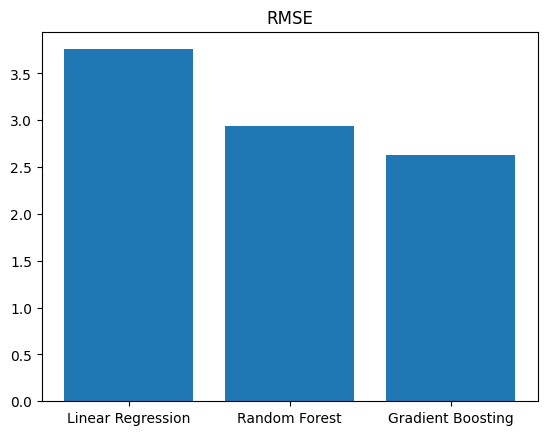

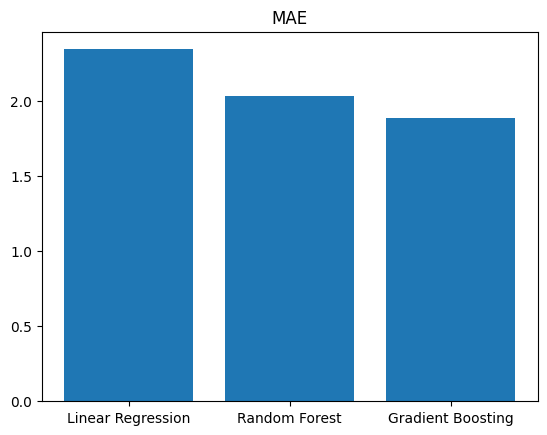

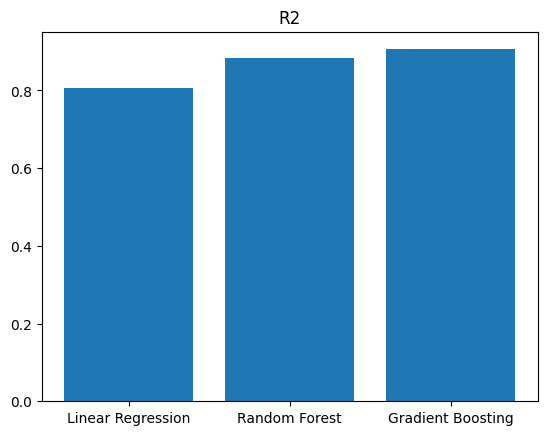

In [9]:
def plot_bar(df, metric):
    plt.figure()
    plt.bar(df["model"], df[metric])
    plt.title(metric)
    plt.show()

plot_bar(results_df, "RMSE")
plot_bar(results_df, "MAE")
plot_bar(results_df, "R2")

In [10]:
from sklearn.impute import SimpleImputer

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rows = []
for name, mdl in models.items():
    # Create a pipeline for cross-validation that includes imputation
    pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("model", mdl)
    ])
    neg_mse = cross_val_score(pipeline, X_full, y, cv=cv, scoring="neg_mean_squared_error")
    r2s = cross_val_score(pipeline, X_full, y, cv=cv, scoring="r2")
    cv_rows.append({
        "model": name,
        "CV_RMSE_mean": np.sqrt(-neg_mse).mean(),
        "CV_R2_mean": r2s.mean()
    })
print(pd.DataFrame(cv_rows))

               model  CV_RMSE_mean  CV_R2_mean
0  Linear Regression      4.159067    0.787590
1      Random Forest      3.507135    0.850541
2  Gradient Boosting      2.971297    0.892423


In [11]:
from sklearn.impute import SimpleImputer

# Create pipelines for GridSearchCV including imputation
pipe_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("rf", RandomForestRegressor(random_state=42, n_jobs=-1))
])

pipe_gbr = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("gbr", GradientBoostingRegressor(random_state=42))
])

rf_grid = {"rf__n_estimators": [200, 400], "rf__max_depth": [None, 6, 10], "rf__min_samples_split": [2, 5, 10]}
rf_search = GridSearchCV(pipe_rf,
                         rf_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

gbr_grid = {"gbr__n_estimators": [200, 400], "gbr__learning_rate": [0.03, 0.05, 0.1], "gbr__max_depth": [2, 3, 4]}
gbr_search = GridSearchCV(pipe_gbr,
                          gbr_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
gbr_search.fit(X_train, y_train)
best_gbr = gbr_search.best_estimator_

# Đánh giá sau tuning
def eval_model(m, name):
    # The fitted model from GridSearchCV is already a pipeline including imputer
    pred = m.predict(X_test)
    return {"model": name,
            "RMSE": rmse(y_test, pred),
            "MAE": mean_absolute_error(y_test, pred),
            "R2": r2_score(y_test, pred)}

tuned_results = [eval_model(best_rf, "Random Forest (Tuned)"),
                 eval_model(best_gbr, "Gradient Boosting (Tuned)")]
print(pd.DataFrame(tuned_results))

                       model      RMSE       MAE        R2
0      Random Forest (Tuned)  2.918760  2.031093  0.883830
1  Gradient Boosting (Tuned)  2.522466  1.815648  0.913235


In [12]:
all_compare = pd.concat([results_df, pd.DataFrame(tuned_results)])
best_row = all_compare.sort_values(by="RMSE").iloc[0]
best_name = best_row["model"]
print("Best model:", best_name)

name_to_model = {"Linear Regression": pipe_lr,
                 "Random Forest": rf,
                 "Gradient Boosting": gbr,
                 "Random Forest (Tuned)": best_rf,
                 "Gradient Boosting (Tuned)": best_gbr}
best_model = name_to_model[best_name]
best_model.fit(X_full, y)

joblib.dump(best_model, "best_model.pkl")
with open("train_columns.json", "w", encoding="utf-8") as f:
    json.dump({"columns": list(X_full.columns), "target": "MEDV", "best_model_name": best_name}, f, indent=2)


Best model: Gradient Boosting (Tuned)


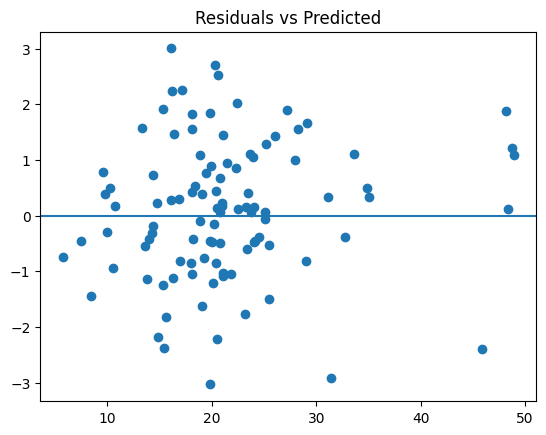

In [13]:
preds_test = best_model.predict(X_test)
residuals = y_test - preds_test
plt.scatter(preds_test, residuals)
plt.axhline(0)
plt.title("Residuals vs Predicted")
plt.show()

In [29]:
# === RUN STREAMLIT WITH NGROK (STABLE) ===
NGROK_TOKEN = "31nCYYDMmx0AGZsJ8JwgqM7gfmt_25bMXMuuCkiELYXxrAjyH"  # <-- DÁN TOKEN THẬT VÀO ĐÂY
APP_FILE = "app.py"  # đổi nếu bạn đặt tên khác

# 0) Cài & dọn
!pip -q install streamlit pyngrok
!fuser -k 8501/tcp 2>/dev/null || true
!fuser -k 8502/tcp 2>/dev/null || true
!pkill -f "streamlit run" 2>/dev/null || true

# 1) Kiểm tra file
import os, time
assert os.path.exists(APP_FILE), f"Không thấy {APP_FILE} trong thư mục hiện tại"

# 2) Chạy streamlit nền (PORT 8502)
!streamlit run {APP_FILE} --server.headless true --server.port 8502 > /tmp/streamlit.log 2>&1 &
time.sleep(3)

# 3) Mở tunnel ngrok và in URL
from pyngrok import ngrok, conf
ngrok.set_auth_token(NGROK_TOKEN)   # nếu token sai sẽ báo ngay ở đây

public_url = ngrok.connect(8502, "http").public_url
print("Public URL:", public_url)

print("\nXem log nếu cần debug:")
!sed -n '1,80p' /tmp/streamlit.log


 17109^C
Public URL: https://3a93fcdde801.ngrok-free.app

Xem log nếu cần debug:



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8502
  Network URL: http://172.28.0.12:8502
  External URL: http://34.87.188.0:8502



In [20]:
!sed -n '1,200p' /tmp/streamlit.log





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8502
  Network URL: http://172.28.0.12:8502
  External URL: http://34.87.188.0:8502



In [21]:
!kill -9 $(lsof -t -i:8501)


kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
